In [1090]:
import numpy as np
import seaborn as sns; 
import matplotlib.pyplot as plt

In [16]:
# def add_dim(x, data = {"depth":0}):
#     if x.shape[0]>0:
#         data["depth"]+=1
#         return np.array([add_dim(x[1:], data) for _ in range(x[0])])
#     else:
#         return Node(0)
        

In [106]:
y = Lattice_2D(x)
type(x)==np.ndarray

True

In [1130]:
def plot_list_ref_vector(lattice, list_ref_vector):
    max_width = 15
    number_vectors = list_ref_vector.shape[0]
    height = max_width // number_vectors
    fig, axs = plt.subplots(ncols=number_vectors, figsize=(max_width, height))
    for i, vector in enumerate(list_ref_vector):
        sns.heatmap(lattice.relative_distance(vector), vmin=0, ax=axs[i])

In [1637]:
class Node():
    def __init__(self, lattice, *args):
        self.lattice = lattice
        self.weight   = np.array(args) 
        self.position = np.array(args)
        
    def get_weight(self):
        return self.weight
    
    def get_position(self):
        return self.position
    
    def distance_to(self, vector):
        return self.lattice.distance_function(vector - self.weight)
    
    def __getitem__(self, i):
        return self.position[i]
    def __setitem__(self, i, value):
        self.position[i] = value
    
    def __add__(self, other):
        try:
            if isinstance(other, Node):
                return other.weight + self.weight
            else:
                return other + self.weight
        except TypeError:
            raise TypeError(f"type {type(self.weight)} and type {type(other)} can not be + ")

    
    def __sub__(self, other):
        try:
            if isinstance(other, Node):
                return other.weight - self.weight
            else:
                return other - self.weight
        except TypeError:
            raise TypeError(f"type {type(self.weight)} and type {type(other)} can not be - ")
    
    def __mul__(self, other):
        try:
            if isinstance(other, Node):
                return other.weight * self.weight
            else:
                return other * self.weight
        except TypeError:
            raise TypeError(f"type {type(self.weight)} and type {type(other)} can not be multiplied")
         
    def __radd__(self, other):
        raise TypeError("please try to change the order (a+b)-> (b+a)")  
    def __rsub__(self, other):
        raise TypeError("please try to change the order (a-b)-> -(b-a)") 
    def __rmult__(self, other):
        raise TypeError("please try to change the order (a*b)-> (b*a)")
        
    def __iadd__(self, other):
        self.weight = self + other
        return self
    def __isub__(self, other):
        self.weight = self - other
        return self    
    def __imult__(self, other):
        self.weight = self * other
        return self
        
            
class Lattice():
    def __init__(self):
        self.lattice = None
        self.distance_function = np.linalg.norm
        self.set_update_function(node_distance = self.node_distance, 
                                 epsilon_0 = 0.8, 
                                 sigma_0   = 20, 
                                 t_max     = 100)
             
    def __getitem__(self, position):
        return self.lattice[position]   
    def __setitem__(self, position, value):
        self.lattice[position] = value
    
    def node_distance(self, node_1, node_2):
        return self.distance_function(node_1.weight-node_2.weight)
    
    def get_node_weight(self, position):
        return self[position].get_weight()
    
    def set_update_function(self, node_distance, epsilon_0, sigma_0, t_max):
        self.update_function = Update(node_distance, epsilon_0, sigma_0, t_max)
        
    def get_weight(self):
        f = np.vectorize(lambda node: node.get_weight(), signature='()->(n)')
        return f(self.lattice)
    
    def get_position(self):
        f = np.vectorize(lambda node: node.get_position(), signature='()->(n)')
        return f(self.lattice)
    
    
    
    def relative_distance(self, ref_vector):
        f = np.vectorize(lambda node: node.distance_to(ref_vector))
        return f(self.lattice)
    
    def find_closest_id(self, ref_vector):
        distance_matrix = self.relative_distance(ref_vector)
        return np.unravel_index(distance_matrix.argmin(), distance_matrix.shape)
    
    def find_closest(self, ref_vector):
        return self.lattice[self.find_closest_id(ref_vector)]
        
    
    
    def run(self, input_vector, t):
        
        best_matching_node = self.find_closest(input_vector)
        
        for node in self:
            update_value = self.update_function.value( reference_vector   = input_vector, 
                                                       best_matching_node = best_matching_node,
                                                       current_node       = node,
                                                       t                  = 0) 

            node += update_value*(node-input_vector)
            
    def train(self, batch):
        for t, input_vector in enumerate(batch):
             self.run(input_vector, t)
    
    def __iter__(self):
        pass
    
    
    
    class DecreasingExp():
        def __init__(self, x_0, x_max):
            self.x_0 = x_0
            self.x_max = x_max
        def value(self, x):
            return self.x_0*np.exp(-x/self.x_max)
    class Normal():
        def __init__(self, node_distance, epsilon, sigma):
            self.distance = node_distance
            self.epsilon  = epsilon
            self.sigma    = sigma
        def value(self, node_i, node_j, t):
            epsilon_t = self.epsilon.value(t)
            d_ij      = self.distance(node_i, node_j)
            sigma_t   = self.sigma.value(t)
            return epsilon_t*np.exp(-d_ij**2/(2*sigma_t**2))

    class Update():
        def __init__(self, node_distance, epsilon_0, sigma_0, t_max):
            node_distance = node_distance

            epsilon   = DecreasingExp(epsilon_0, t_max)
            sigma     = DecreasingExp(sigma_0,   t_max)
            self.coef = Normal(node_distance, epsilon, sigma)

        def value(self, reference_vector, best_matching_node, current_node, t):
            return self.coef.value(best_matching_node, current_node, t)
    
    
    
    
class Lattice_1D(Lattice):
    def __init__(self, list_dim):
        super().__init__()
        self.list_dim = list_dim
        self.lattice = np.array([Node(self, i) for i in range(list_dim[0])])
                
    def __iter__(self):
        for i in range(self.list_dim[0]):
            yield self.lattice[i]

            
class Lattice_2D(Lattice):
    def __init__(self, list_dim):
        super().__init__()
        self.list_dim = list_dim
        self.lattice = np.array([[Node(self, i, j) for j in range(list_dim[1])] 
                                                   for i in range(list_dim[0])])
        
    
    def __iter__(self):
        for i in range(self.list_dim[0]):
            for j in range(self.list_dim[1]):
                yield self.lattice[i][j]

# 2D

In [1638]:
lattice_dim = np.array([100, 100])
lattice = Lattice_2D(lattice_dim)
lattice.set_update_function(node_distance = lattice.node_distance, 
                             epsilon_0 = 1, 
                             sigma_0 = 20, 
                             t_max = 100)

In [1639]:
ref_vector_1 = np.array([10, 10])
ref_vector_2 = np.array([80, 50])
ref_vector_3 = np.array([0, 99])
batch = np.concatenate([[ref_vector_1, ref_vector_2, ref_vector_3]])

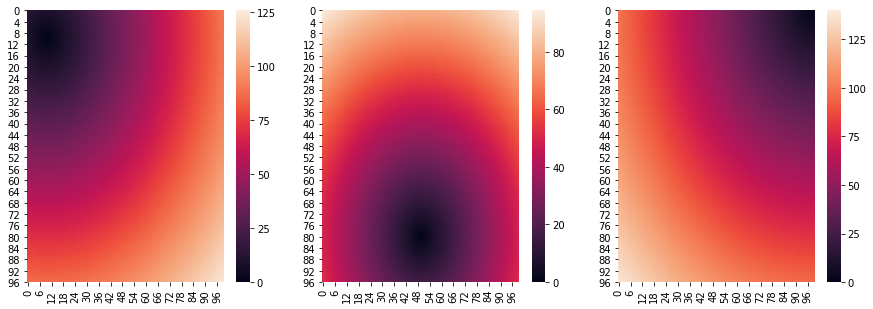

In [1640]:
plot_list_ref_vector(lattice, batch)

In [1644]:
lattice.train(batch)

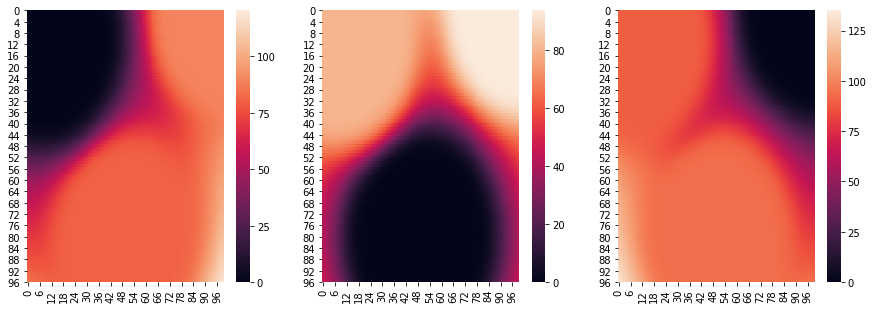

In [1645]:
plot_list_ref_vector(lattice, batch)

# 1D

In [1622]:
lattice_dim = np.array([100])
lattice = Lattice_1D(lattice_dim)
lattice.set_update_function(node_distance = lattice.node_distance, 
                             epsilon_0 = 1, 
                             sigma_0 = 3, 
                             t_max = 20)

In [1623]:
ref_vector_1 = np.array([1])
ref_vector_2 = np.array([30])
ref_vector_3 = np.array([40])
batch = np.concatenate([[ref_vector_1, ref_vector_2, ref_vector_3]])
# batch = np.concatenate([[ref_vector_1]])

In [1624]:
nb_train = 100
train_batch = np.repeat([batch], nb_train, axis = 0).reshape([-1, 1])

In [1625]:
train_batch.shape

(300, 1)

In [1626]:
# sns.heatmap(lattice.relative_distance(ref_vector_1)[np.newaxis, :], vmin=0)

In [1627]:
lattice.train(train_batch)

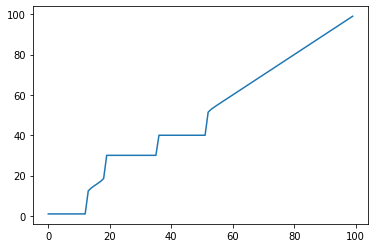

In [1628]:
plt.plot(lattice.get_weight())

In [1629]:
lattice.get_weight().shape

(100, 1)

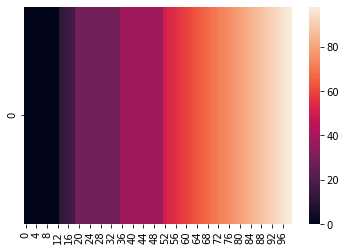

In [1630]:
sns.heatmap(lattice.relative_distance(ref_vector_1)[np.newaxis, :], vmin=0)

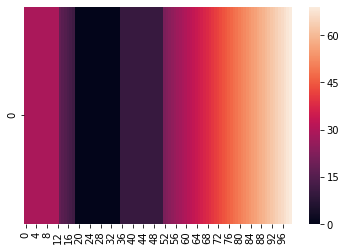

In [1631]:
sns.heatmap(lattice.relative_distance(ref_vector_2)[np.newaxis, :], vmin=0)

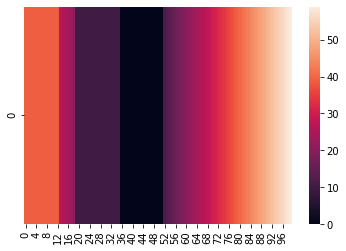

In [1632]:
sns.heatmap(lattice.relative_distance(ref_vector_3)[np.newaxis, :], vmin=0)